# GAN

## 모델 생성

In [ ]:
# model.py
import tensorflow as tf
from tensorflow.keras import models, layers, utils


class BuildModel() :
  def __init__(self, img_shape, z_dim) :
    self.img_shape = img_shape
    self.z_dim = z_dim
# Generator

  def build_generator(self,kernel_size = 5, activation = 'relu', last_activation = 'sigmoid') :
    h,w,c = self.img_shape
    z = layers.Input(shape = [self.z_dim]) # 길이가 z_dim인 벡터
    y = layers.Dense(int(w/4)*int(h/4)*128)(z)
    y = layers.Reshape([int(w/4),int(h/4),128])(y)

    y = layers.BatchNormalization()(y)
    y = layers.Conv2DTranspose(64,kernel_size = kernel_size, padding = 'same', strides = 2, activation = activation)(y)
    y = layers.BatchNormalization()(y)
    y = layers.Conv2DTranspose(c,kernel_size = kernel_size, padding = 'same', strides = 2, activation = last_activation)(y)
    return models.Model(z, y, name = 'Generator')


  # Discriminator

  def build_discriminator(self, kernel_size = 5, activation = 'relu', last_activation = 'sigmoid') :
    x = layers.Input(shape = self.img_shape)
    y = layers.Conv2D(64,kernel_size = kernel_size, strides = 2, padding = 'same', activation = activation)(x)
    y = layers.Dropout(.5)(y)
    y = layers.Conv2D(128,kernel_size = kernel_size, strides = 2, padding = 'same', activation = activation)(y)
    y = layers.Dropout(.5)(y)
    y = layers.Flatten()(y)
    y = layers.Dense(1, activation = last_activation)(y)
    return models.Model(x, y, name = 'Discriminator')

# 모델 구성

In [ ]:
IMG_SHAPE = (28,28,1)
Z_DIM = 128
builder = BuildModel(IMG_SHAPE, Z_DIM)
gene = builder.build_generator()
disc = builder.build_discriminator()
gene.summary()
disc.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense_4 (Dense)             (None, 6272)              809088    
                                                                 
 reshape_3 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 batch_normalization_6 (Batc  (None, 7, 7, 128)        512       
 hNormalization)                                                 
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 14, 14, 64)       204864    
 ranspose)                                                       
                                                                 
 batch_normalization_7 (Batc  (None, 14, 14, 64)       25

# 데이터 로더

In [ ]:
# data_loader.py

import tensorflow as tf
import numpy as np

# 정규화 - minmax : 0~1, standard norm : -1~1
def mnist_loader(standard = False) :
  (x_train, y_train), (x_test,y_test) = tf.keras.datasets.mnist.load_data()
  x_train = x_train / 255. # 0~1
  x_test = x_test / 255. # 0~1
  if standard :
    x_train = (x_train*2)-1
    x_test = (x_test*2)-1

  return x_train,x_test,y_train,y_test

def fmnist_loader(standard = False) :
  (x_train, y_train), (x_test,y_test) = tf.keras.datasets.fashion_mnist.load_data()
  x_train = x_train / 255.
  x_test = x_test / 255.
  if standard :
    x_train = (x_train*2)-1
    x_test = (x_test*2)-1

  return x_train,x_test,y_train,y_test

def cifar10_loader(standard = False) :
  (x_train, y_train), (x_test,y_test) = tf.keras.datasets.cifar10.load_data()
  x_train = x_train / 255.
  x_test = x_test / 255.
  if standard :
    x_train = (x_train*2)-1
    x_test = (x_test*2)-1

  return x_train,x_test,y_train,y_test
  

import matplotlib.pyplot as plt
import numpy as np

def display_sample_img(samples, grid, standard=False, size=1):
  h, w = grid
  n = np.cumprod(grid)[-1]
  plt.figure(figsize=(w*size,h*size))
  for i, sample in enumerate(samples[:n]):
    if i==n: break
    if standard:
      sample = ( sample  + 1. ) / 2.
    sample = np.clip(sample, 0, 1)
    plt.subplot(h,w,i+1)
    if sample.shape[-1]==1: plt.imshow(sample[:,:,0], cmap='gray_r')
    else: plt.imshow(sample)
    plt.xticks([]);plt.yticks([])
  plt.show()


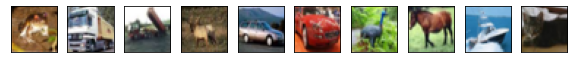

In [ ]:
x_train,_,_,_ = cifar10_loader()
display_sample_img(x_train[:10], (10,10))

# GAN

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers, utils
from utils import display_sample_img

class GAN():
  def __init__(self, gene, disc, img_shape, noise_dims):
    self.name = 'GAN'
    self.gene = gene
    self.disc = disc
    self.img_shape = img_shape
    self.noise_dims = noise_dims

  def compile(self, 
              loss = 'binary_crossentropy',
              optimizer = 'adam'):
    
    self.disc.compile(loss = loss, optimizer = optimizer)
    self.disc.trainable = False
    
    input_noise = layers.Input(shape=self.noise_dims)
    fake_img = self.gene(input_noise)
    logit = self.disc(fake_img)

    self.gan = models.Model(input_noise, logit, name=self.name)
    self.gan.compile(loss = loss, optimizer = optimizer)

  def _make_datasets(self, x_data):
      dataset = tf.data.Dataset.from_tensor_slices(x_data).shuffle(1)
      dataset = dataset.batch(self.batch_size, drop_remainder=True).prefetch(1)
      return dataset

  def _make_constants(self):
      zeros = tf.constant([0.], shape=[self.batch_size, 1])
      ones = tf.constant([1.], shape=[self.batch_size, 1] )
      return zeros, ones
  
  def _make_random(self):
      return tf.random.normal(shape=[self.batch_size, self.noise_dims])

  def fit(self, 
          x_data, 
          epochs=1,
          batch_size=32,
          standard = False
          ):
    if standard :
      x_data = (x_data*2)-1
     # setting
    self.batch_size = batch_size
    train_ds = self._make_datasets(x_data)
    zeros, ones = self._make_constants()
    
    # train
    history = {'d_loss':[], 'g_loss':[]}
    for epoch in range(1, 1+epochs):
      if epoch>1: 
        for h in history: history[h].append(0)

        for real_imgs in train_ds:           
            # phase 1 - training the discriminator
            fake_imgs = self.gene.predict_on_batch(self._make_random())
            
            self.disc.trainable = True
            d_loss_real = self.disc.train_on_batch(real_imgs, ones)
            d_loss_fake = self.disc.train_on_batch(fake_imgs, zeros)
            d_loss = (0.5*d_loss_real) + (0.5*d_loss_fake)
            
            # phase 2 - training the generator
            self.disc.trainable = False
            g_loss = self.gan.train_on_batch(self._make_random() , ones)
            
            history['d_loss'][-1]+=d_loss
            history['g_loss'][-1]+=g_loss
        
        # end 1 epoch        
        print('* epoch: %i, d_loss: %f, g_loss: %f'%( epoch
                                                    , history['d_loss'][-1]
                                                    , history['g_loss'][-1]))
        
      fake_imgs = self.gene.predict(self._make_random())
      display_sample_img(fake_imgs, (2,8), standard=True, size=2)

In [ ]:
x_train.shape

(50000, 32, 32, 3)

Model: "GAN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 128)]             0         
                                                                 
 Generator (Functional)      (None, 32, 32, 3)         1267203   
                                                                 
 Discriminator (Functional)  (None, 1)                 217985    
                                                                 
Total params: 1,485,188
Trainable params: 1,266,819
Non-trainable params: 218,369
_________________________________________________________________


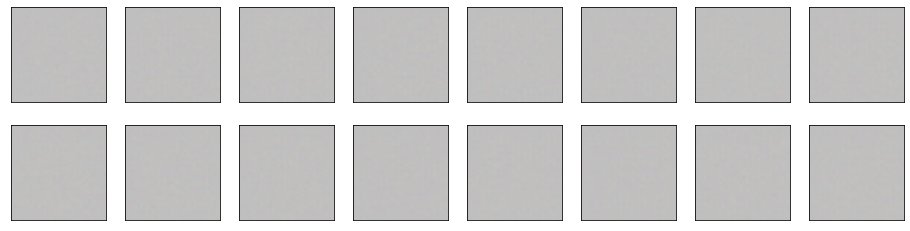

* epoch: 2, d_loss: 689.260044, g_loss: 2960.374097


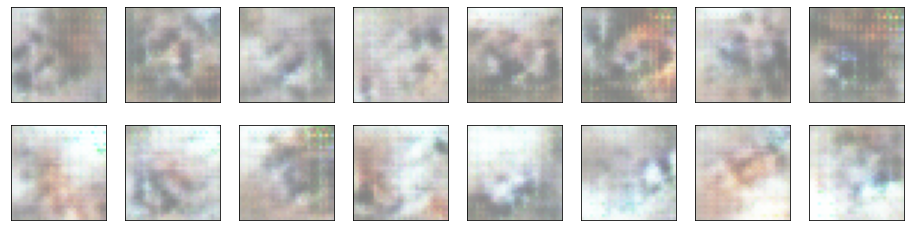

* epoch: 3, d_loss: 875.318482, g_loss: 1907.969022


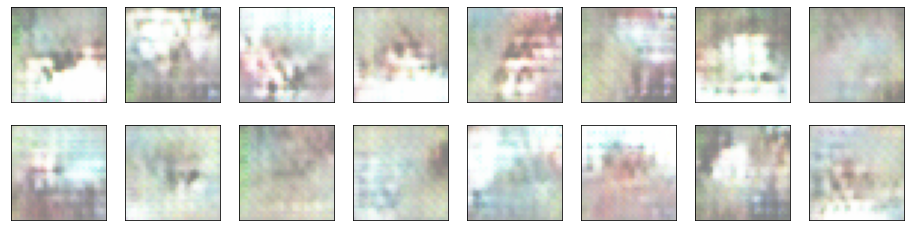

* epoch: 4, d_loss: 860.096024, g_loss: 2023.721827


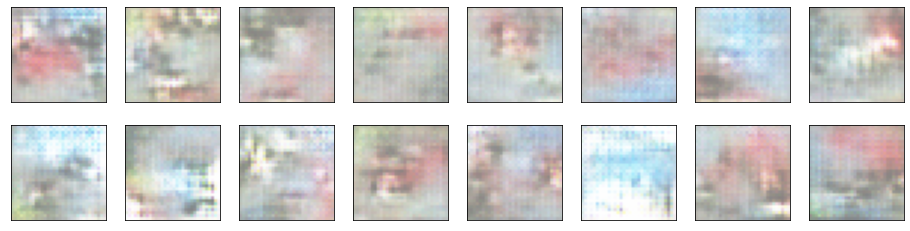

* epoch: 5, d_loss: 800.707266, g_loss: 2322.875138


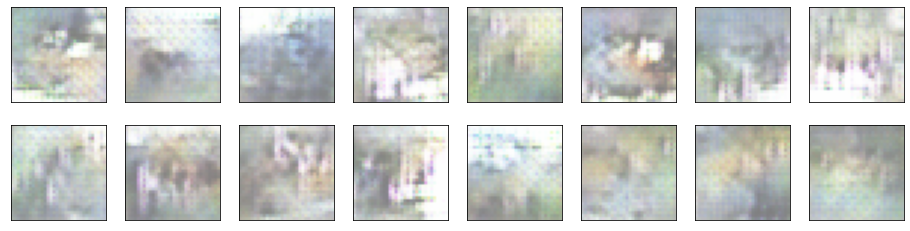

In [ ]:
from gan import GAN

img_shape = (32,32,3)
Z_DIM = 128
builder = BuildModel(img_shape, Z_DIM)
gene = builder.build_generator()
disc = builder.build_discriminator()

model = GAN(gene, disc, img_shape, Z_DIM)
model.compile()
model.gan.summary()
model.fit(x_train, epochs=5)